---

[Brenno Cabella]

Date: 24/09/2019

---

# Credit Card Fraud Detection

Anonymized credit card transactions labeled as fraudulent or genuine

from:
https://www.kaggle.com/mlg-ulb/creditcardfraud



### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Summary

### Pre-processing

The data is already pre-processed, therefore steps such as standardization, missing data handling, categorical data encoding, removal of non-informative variables etc. wont be necessary.
Also we should not have issues with correlated features, since the features presented are principal components (PCA applied) of the orginal data.

### Data exploration

- Data information

- General descriptive statistics

- Characteristics of the features 'Amount' and 'Time'

- Comparing the top 10 'Amount' in fraud vs 'non-fraud' transactions

- Transactions time pattern 


### Method

**XGBoost** (Extreme Gradient Boosting)

The gradient boosted trees has been around for a while, and there are a lot of materials on the topic. 
XGBoost (Extreme Gradient Boosting), where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.

More info here: 
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

**Steps**
- Cross-validation

- Features importance

- Predict test data using optimal parameters

- Precision-recall curve

**Extra analysis**

- Errors as a function of threshold

### Perspectives 


In [54]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from matplotlib.pyplot import figure
from matplotlib import pyplot
from random import sample
import random 

In [24]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [11, 7]

## Data exploration

In [3]:
Data=pd.read_csv('data/creditcard.csv')# read data
Data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Shape: Rows x Columns

In [51]:
print("(Rows, Columns) of Data:",Data.shape)

(Rows, Columns) of Data: (284807, 31)


### Data information

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

### General descriptive statistics

In [5]:
Data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Comparing the top 10 'Amount' in fraud vs 'non-fraud' transactions

The amount of money spent in fraudulent transactions seems to have 'prefered' values.
Figure below presents the top 10 most frequent amounts in US in fraudulent transactions and compare it with non-fraudulent ones.
For instance, the proportion of $1.00 transactions is ~25%  in fraudulent and ~5% for non-fraudulent transaction (5 times higher!)
This is curious, and suggests that 'Amount' may be an important feature to distinguish fraud from non-fraud.

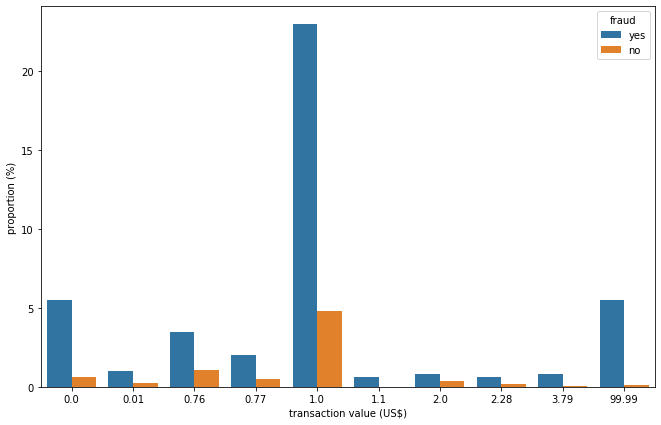

In [25]:
# Choose top NAmounts to plot
NAmounts=10
DataFraud=Data[Data['Class']==1]
DataNotFraud=Data[Data['Class']==0]
FraudAmounts=DataFraud['Amount'].value_counts()[0:NAmounts,]*100/len(DataFraud)
NotFraudAmounts=DataNotFraud.loc[DataNotFraud['Amount'].isin(FraudAmounts.index),'Amount'].value_counts()*100/len(DataNotFraud)
AmountAux=pd.concat([FraudAmounts, NotFraudAmounts])
AmountsPlot=pd.DataFrame(AmountAux)
AmountsPlot=AmountsPlot.reset_index()
AmountsPlot.loc[0:NAmounts,'fraud']='yes'
AmountsPlot.loc[NAmounts:len(AmountsPlot),'fraud']='no'
AmountsPlot.columns = ['transaction value (US$)','proportion (%)','fraud']
ax = sns.barplot(x="transaction value (US$)", y="proportion (%)", hue="fraud", data=AmountsPlot)

### Checking the percentage of fraudulent transactions

As mentioned in the chalenge proposal, the percentage of fraudulent transactions are very low when compared to the non-fraudulent.

In [8]:
print('Percentage of fraud tansactions = ' + str(round(len(DataFraud)*100/len(Data),3))+ '%')

Percentage of fraud tansactions = 0.173%


### Transactions time pattern 

Using the 'Time' feature from the data, it is possible to observe some kind of seasonality. The two peaks seems to be related to day/night cycles within the period that the data was collected (two days). 
Note that the non-fraud transactions presents a more defined seasonality with a clearer mimimum.

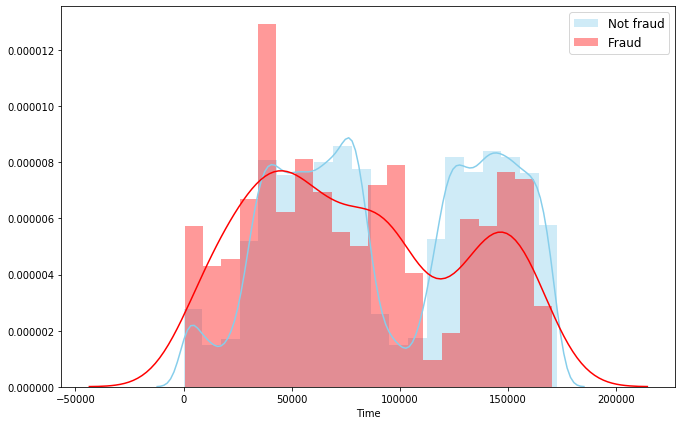

In [26]:
sns.distplot(DataNotFraud['Time'],color="skyblue",label="Not fraud",bins=20)
sns.distplot(DataFraud['Time'],color="red",label="Fraud",bins=20)
plt.legend(prop={'size': 12})
plt.show()

---

## XGBoost

*XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.*

From: **XGBoost Documentation**: https://xgboost.readthedocs.io/en/latest/index.html

In [11]:
X=Data.drop('Class',axis=1)
y=Data['Class']

> Separate 20% of the data for test.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid search cross validation for parameter optmization

**Stratified Shuffle Split** is used for cross-validation.
Samples are randomly selected from the train set where 30% is used for validation.
For each split, the proportion of classes (0,1) is kept constant (equal to the data's proportion).

A simple grid is used with 3 values each:

- 'n_estimators': [50,100,150],
- 'max_depth': [3,6,9],
- 'learning_rate': [0.2,0.3,0.4]

**Chosen metric (F1)**

Accuracy here can me misleading since the presence of a major group (class 0 ~ 99%) can distort the real performance of the method.
F1 score might be a better measure to use if we need to seek a balance between precision and recall and there is an uneven class distribution (large number of actual negatives).


In [13]:
# Parameters for Stratified Shuffle Split
n_splits=3
test_size=0.3
random_state=0

In [15]:
parameters = {'n_estimators': [50,100,150],
              'max_depth': [3,6,9],
              'learning_rate': [0.2,0.3,0.4]}
base_model = xgb.XGBClassifier()
skf = StratifiedShuffleSplit(n_splits=n_splits, 
                             test_size=test_size,
                             random_state=random_state)
search_XGB = GridSearchCV(base_model, 
                          parameters, 
                          scoring='f1', 
                          n_jobs=-1, 
                          cv=skf,
                          return_train_score=True)
search_XGB.fit(X_train, y_train)
SearchDataFrame=pd.DataFrame(search_XGB.cv_results_).sort_values(by='rank_test_score')
SearchDataFrame = SearchDataFrame[['param_n_estimators',
                                   'param_max_depth',
                                   'param_learning_rate',
                                   'mean_train_score',
                                   'std_train_score',
                                   'mean_test_score',
                                   'std_test_score']]
best_params=SearchDataFrame.reset_index().loc[0,:]
best_params

index                         26
param_n_estimators           150
param_max_depth                9
param_learning_rate          0.4
mean_train_score               1
std_train_score                0
mean_test_score         0.872351
std_test_score         0.0165375
Name: 0, dtype: object

###  Create model with optmized parameters

With the optmized parameters in hand, the model is applied to all train data.

In [16]:
model_XGB = xgb.XGBClassifier(n_estimators=best_params['param_n_estimators'],
                              max_depth=best_params['param_max_depth'],
                              learning_rate=best_params['param_learning_rate'])
model_XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Features importance

From the features importance plot, 'V14' is the most discriminative variable, followed by 'V4' and 'Amount'.

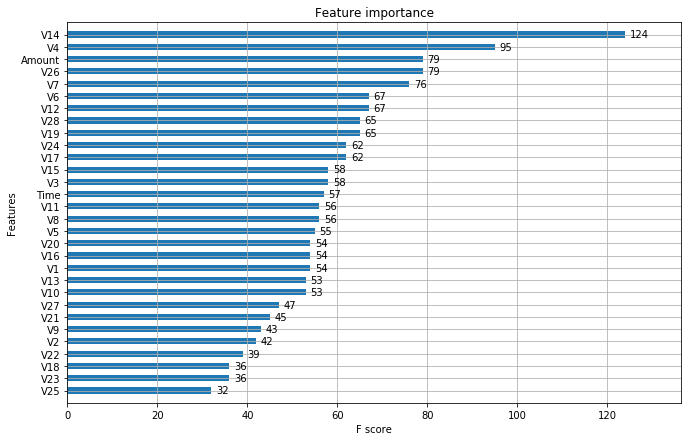

In [27]:
plot_importance(model_XGB,height=0.5)
pyplot.show()

###  Predict test data using optimal parameters

In [32]:
predictions = model_XGB.predict(X_test)
predictions_prob = model_XGB.predict_proba(X_test)
conf_aux=confusion_matrix(y_test, predictions)
print('True Negatives: ' + str(conf_aux[0][0]))
print('True Positives: ' + str(conf_aux[1][1]))
print('False Negatives: ' + str(conf_aux[1][0]))
print('False Positives: ' + str(conf_aux[0][1]))

True Negatives: 56860
True Positives: 77
False Negatives: 21
False Positives: 4


### Precision-recall curve

The confusion matrix above was obtained considering a fixed probability threshold, i.e. if the probability of Class=1 is greater than 0.5 the class is considered 1. However, for different thresholds, the matrix values can change, consequently increasing and/or decreasing the precsion and recall. This relation can be better visualized in the Precision Recall plot, where each value of threshold is considered.

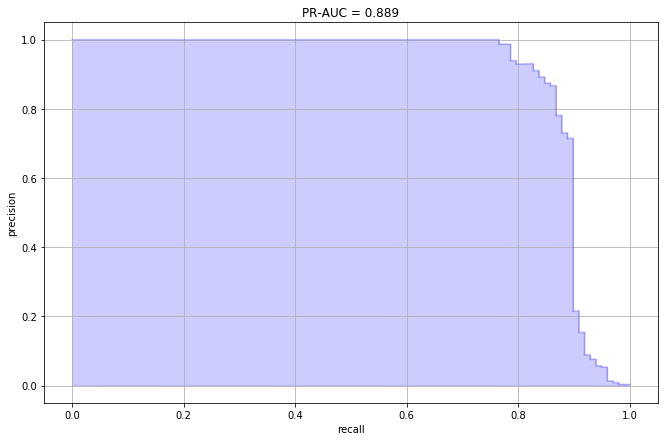

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions_prob[:,1])
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('recall')
plt.ylabel('precision')
area = metrics.auc(recall, precision)
plt.title('PR-AUC = '+str(round(area,3)))
plt.grid(True)

### Errors as a function of threshold

For the data provided and model obtained, this a simple analysis showing the number of False Positives (FP) and False Negative (FN) as a function of a given probability threshold. 
This probability is obtained with the predict_proba function.

Probility of class 0 = p(0)
Probility of class 1 = p(1)

They are rescaled in terms of log odds ratio:

threshold = log(p(1)/p(0))

The idea is to search for a threshold that better satisfies the cost-benefit relation between FP and FN.
Which is more important, to minimize the fraud with the cost of having more genuinde transactions being detected as fraud or minimize false fraud detections with the cost of having more frauds undetected?
This relation can be examined in the plot below.

In [34]:
matrix_threshold=pd.DataFrame(columns=['threshold','FP','FN','TP','TN'])
y_aux=np.log(predictions_prob[:,1]/predictions_prob[:,0])
y_aux_bins=np.linspace(y_aux.min(),y_aux.max(),1000) 
count=0
for i in y_aux_bins:
    aux_y_prob=(y_aux>=i)
    matrix_threshold.loc[count,'threshold']=i
    matrix_threshold.loc[count,'FP']=sum((aux_y_prob-y_test)>0) #False positive
    matrix_threshold.loc[count,'FN']=sum((y_test-aux_y_prob)>0) #False negative
    matrix_threshold.loc[count,'TP']=sum((aux_y_prob+y_test)==2) #True positive
    matrix_threshold.loc[count,'TN']=sum((aux_y_prob+y_test)==0) #True negative
    count+=1

In [36]:
matrix_threshold.head()

,threshold,FP,FN,TP,TN
0,-19.306,56864,0,98,0
1,-19.2765,56863,0,98,1
2,-19.2469,56862,0,98,2
3,-19.2173,56862,0,98,2
4,-19.1878,56862,0,98,2


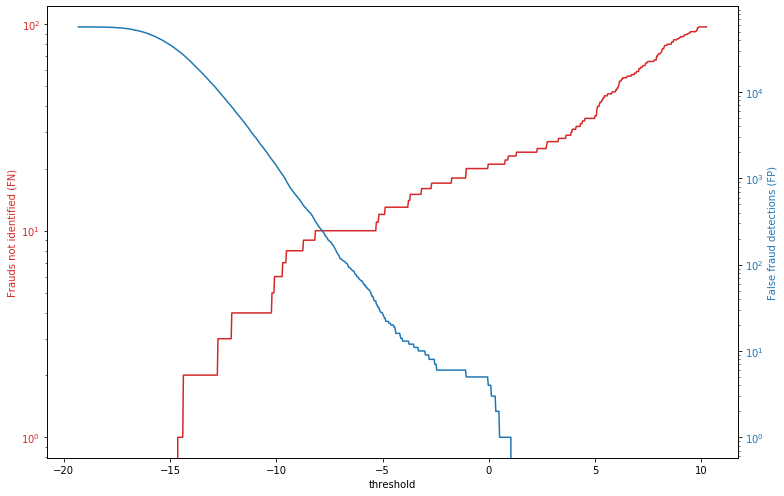

In [48]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('threshold')
ax1.set_ylabel('Frauds not identified (FN)', color=color)
ax1.plot(matrix_threshold['threshold'],matrix_threshold['FN'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('False fraud detections (FP)', color=color)  
ax2.plot(matrix_threshold['threshold'],matrix_threshold['FP'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')
ax2.set_yscale('log')
#plt.xlim((-5, 10))
#ax2.set_ylim(0, 50)
fig.tight_layout()  
plt.show()

## Perspectives


- One of the options in xgboost method is to change the parameter 'scale_pos_weight', changing the weights of positive obeservations. This should be useful for our unbalanced classes.


- Include 'amount' feature in the model as part of the cost function (example-dependant cost-senstive learning). It would be important to create a model that minimizes false negative for higher amounts (\$).


- Other methods for parameter optmization may be implemented. Random search and/or Bayesian model-based optimization can improve model performance. Here, few values of parameters in a small grid search were used just to present the modelling process in general. 


- A cost-benefit analysis, concerning false positives and false negatives may be taken into account considering the client perspective. 


---